#Downloading Dependencies

In [ ]:
!pip install download mindspore
# !pip uninstall mindspore -y
!pip install mindspore-gpu

  Using cached mindspore-2.5.0-cp311-cp311-manylinux1_x86_64.whl.metadata (18 kB)
Using cached mindspore-2.5.0-cp311-cp311-manylinux1_x86_64.whl (962.0 MB)


ERROR: Could not find a version that satisfies the requirement mindspore-gpu (from versions: none)
ERROR: No matching distribution found for mindspore-gpu


#Downloading The Dataset

In [ ]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

download(url, "./datasets-cifar10-bin", kind="tar.gz", replace=True)



file_sizes: 100%|████████████████████████████| 170M/170M [00:14<00:00, 11.8MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./datasets-cifar10-bin


'./datasets-cifar10-bin'

#Basic Preprocessing and Creating the CIFAR-10 dataset for training and validation using MindSpore.

In [ ]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from mindspore import dtype as mstype
import os

data_dir = "./datasets-cifar10-bin/cifar-10-batches-bin"
batch_size = 256
image_size = 32
workers = min(4, os.cpu_count())
num_classes = 10
def create_dataset_cifar10(dataset_dir, usage, resize, batch_size, workers):

    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir,
                                 usage=usage,
                                 num_parallel_workers=workers,
                                 shuffle=True)

    trans = []
    if usage == "train":
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]
    target_trans = transforms.TypeCast(mstype.int32)
    # Data transformation
    data_set = data_set.map(operations=trans,
                            input_columns='image',
                            num_parallel_workers=workers)

    data_set = data_set.map(operations=target_trans,
                            input_columns='label',
                            num_parallel_workers=workers)

    # Batching
    data_set = data_set.batch(batch_size)

    return data_set
# Obtain the preprocessed training and testing datasets
dataset_train = create_dataset_cifar10(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_cifar10(dataset_dir=data_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()


#Visualizing The Dataset

Image shape: (256, 3, 32, 32), Label shape: (256,)
Labels: [4 8 9 0 3 2]


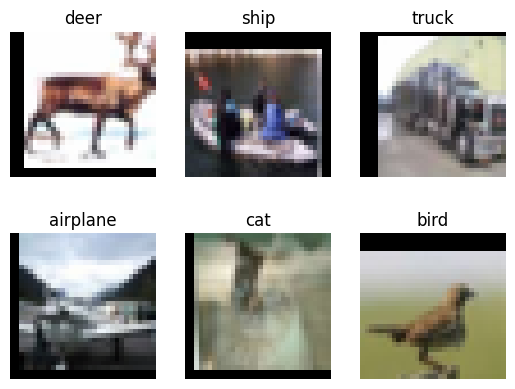

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

# The labels for the first six pictures in the training dataset
print(f"Labels: {labels[:6]}")

classes = []

with open(data_dir + "/batches.meta.txt", "r") as f:
    for line in f:
        line = line.rstrip()
        if line:
            classes.append(line)

# First six pictures in the training dataset
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()


# Defining a Residual Block for ResNet  
This cell defines the core building block of a ResNet model:  

1. **Imports**  
   - Import necessary types and MindSpore modules.  

2. **Weight Initialization**  
   - Initialize convolutional and batch norm layers using a normal distribution.  

3. **ResidualBlockBase Class**  
   - Defines two convolutional layers with batch normalization and ReLU activation.  
   - Implements a shortcut connection (identity mapping).  
   - Optionally includes downsampling to match dimensions when input and output sizes differ.  

4. **Forward Pass (`construct` method)**  
   - Pass input through two convolutional layers + batch norm + ReLU.  
   - Add shortcut connection (with downsampling if needed).  
   - Apply final ReLU activation to the sum of main and shortcut paths.  


In [ ]:
from typing import Type, Union, List, Optional
import mindspore.nn as nn
from mindspore.common.initializer import Normal

weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

class ResidualBlockBase(nn.Cell):
    expansion: int = 1

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d(out_channel)
        else:
            self.norm = norm

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.conv2 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, weight_init=weight_init)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        identity = x  # shortcut

        out = self.conv1(x)  # First layer of the main body: 3 x 3 convolutional layer
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # Second layer of the main body: 3 x 3 convolutional layer
        out = self.norm(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)
        out += identity  # output the sum of the main body and the shortcuts
        out = self.relu(out)

        return out


#Implementation of Residual Block with Expansion in ResNet

In [ ]:
class ResidualBlock(nn.Cell):
    expansion = 4  # The number of convolution kernels at the last layer is four times that of convolution kernels at the first layer.

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=1, weight_init=weight_init)
        self.norm1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.norm2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion,
                               kernel_size=1, weight_init=weight_init)
        self.norm3 = nn.BatchNorm2d(out_channel * self.expansion)

        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):

        identity = x  # shortcut

        out = self.conv1(x)  # First layer of the main body: 1 x 1 convolutional layer
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)  # Second layer of the main body: 3 x 3 convolutional layer
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)  # Third layer of the main body: 1 x 1 convolutional layer
        out = self.norm3(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity  # The output is the sum of the main body and the shortcut.
        out = self.relu(out)

        return out


# Creating a Layer of Residual Blocks  
This cell defines a function to create a full layer of residual blocks:  

1. **Function Parameters**  
   - `last_out_channel` – Number of output channels from the previous layer.  
   - `block` – Type of residual block (basic or bottleneck).  
   - `channel` – Number of channels for the current layer.  
   - `block_nums` – Number of residual blocks to stack.  
   - `stride` – Stride for the first block in the layer (default = 1).  

2. **Downsample (Shortcut Connection)**  
   - If the stride is not 1 or the input/output channels don't match, a 1x1 convolution + batch norm is used to match dimensions.  

3. **Create Layer**  
   - First block includes downsampling (if needed).  
   - Remaining blocks are stacked with matching input and output channels.  

4. **Return Layer**  
   - Combine all blocks into a `SequentialCell` for easy layer construction.  


In [ ]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts


    if stride != 1 or last_out_channel != channel * block.expansion:

        down_sample = nn.SequentialCell([
            nn.Conv2d(last_out_channel, channel * block.expansion,
                      kernel_size=1, stride=stride, weight_init=weight_init),
            nn.BatchNorm2d(channel * block.expansion, gamma_init=gamma_init)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample))

    in_channel = channel * block.expansion
    for _ in range(1, block_nums):

        layers.append(block(in_channel, channel))

    return nn.SequentialCell(layers)


#This cell defines the complete **ResNet architecture** using residual blocks:  


In [ ]:
from mindspore import load_checkpoint, load_param_into_net


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = nn.ReLU()
        # At the first convolutional layer, the number of the input channels is 3 (color image) and that of the output channels is 64.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, weight_init=weight_init)
        self.norm = nn.BatchNorm2d(64)
        # Maximum pooling layer, reducing the image size
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # Define each residual network structure block
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # average pooling layer
        self.avg_pool = nn.AvgPool2d()
        # flattern layer
        self.flatten = nn.Flatten()
        # fully-connected layer
        self.fc = nn.Dense(in_channels=input_channel, out_channels=num_classes)

    def construct(self, x):

        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x


# Loading and Initializing ResNet Model  


In [ ]:
def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrained_ckpt: str,
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # load pre-trained models
        download(url=model_url, path=pretrained_ckpt, replace=True)
        param_dict = load_checkpoint(pretrained_ckpt)
        load_param_into_net(model, param_dict)

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    """ResNet50 model"""
    resnet50_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/models/application/resnet50_224_new.ckpt"
    resnet50_ckpt = "./LoadPretrainedModel/resnet50_224_new.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes,
                   pretrained, resnet50_ckpt, 2048)


# Defining the ResNet50 network.

In [ ]:
network = resnet50(pretrained=True)

# Size of the input layer of the fully-connected layer
in_channel = network.fc.in_channels
fc = nn.Dense(in_channels=in_channel, out_channels=10)
# Reset the fully-connected layer.
network.fc = fc



file_sizes: 100%|████████████████████████████| 102M/102M [00:10<00:00, 9.86MB/s]
Successfully downloaded file to ./LoadPretrainedModel/resnet50_224_new.ckpt


## Defining the Training Setup

This cell sets up the learning rate, optimizer, and training step for the ResNet model:

1. **Learning Rate Schedule**

2. **Optimizer**

3. **Loss Function**

4. **Forward Function**


In [ ]:
# Set the learning rate
num_epochs = 5
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# Define optimizer and loss function
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

def forward_fn(inputs, targets):
    logits = network(inputs)
    loss = loss_fn(logits, targets)
    return loss

grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)
def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss


#Setting Up Training and Validation Data

This cell sets up data loaders, checkpoint handling, and training state tracking:

1. **Data Loaders**

   - `data_loader_train` – Creates an iterator for the training dataset for `num_epochs`.
   - `data_loader_val` – Creates an iterator for the validation dataset for `num_epochs`.

2. **Best Accuracy Tracking**

3. **Checkpoint Directory**

   - `best_ckpt_dir` – Directory to store the best model checkpoint.
   - `best_ckpt_path` – Path for saving the best model weights.

4. **Directory Creation**


In [ ]:
import os

data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/resnet50-best.ckpt"

if not os.path.exists(best_ckpt_dir):
    os.mkdir(best_ckpt_dir)


#Training and Evaluation Functions  


In [ ]:
import mindspore.ops as ops


def train(data_loader, epoch):
    losses = []
    network.set_train(True)

    for i, (images, labels) in enumerate(data_loader):
        loss = train_step(images, labels)
        if i % 100 == 0 or i == step_size_train - 1:
            print('Epoch: [%3d/%3d], Steps: [%3d/%3d], Train Loss: [%5.3f]' %
                  (epoch + 1, num_epochs, i + 1, step_size_train, loss))
        losses.append(loss)

    return sum(losses) / len(losses)


def evaluate(data_loader):
    network.set_train(False)

    correct_num = 0.0  # Number of correct predictions
    total_num = 0.0  # Total number of predictions

    for images, labels in data_loader:
        logits = network(images)
        pred = logits.argmax(axis=1)  # Prediction results
        correct = ops.equal(pred, labels).reshape((-1, ))
        correct_num += correct.sum().asnumpy()
        total_num += correct.shape[0]

    acc = correct_num / total_num  # Accuracy

    return acc


#Training loop

In [ ]:
print("Starting Training ...")

for epoch in range(num_epochs):
    curr_loss = train(data_loader_train, epoch)
    curr_acc = evaluate(data_loader_val)

    print("-" * 50)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
        epoch+1, num_epochs, curr_loss, curr_acc
    ))
    print("-" * 50)

    # Save the model that has achieved the highest prediction accuracy
    if curr_acc > best_acc:
        best_acc = curr_acc
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)


Start Training Loop ...
Epoch: [  1/  5], Steps: [  1/196], Train Loss: [2.374]
Epoch: [  1/  5], Steps: [101/196], Train Loss: [1.453]
Epoch: [  1/  5], Steps: [196/196], Train Loss: [1.238]
--------------------------------------------------
Epoch: [  1/  5], Average Train Loss: [1.628], Accuracy: [0.604]
--------------------------------------------------
Epoch: [  2/  5], Steps: [  1/196], Train Loss: [1.107]
Epoch: [  2/  5], Steps: [101/196], Train Loss: [0.957]
Epoch: [  2/  5], Steps: [196/196], Train Loss: [1.067]
--------------------------------------------------
Epoch: [  2/  5], Average Train Loss: [1.011], Accuracy: [0.688]
--------------------------------------------------
Epoch: [  3/  5], Steps: [  1/196], Train Loss: [0.842]
Epoch: [  3/  5], Steps: [101/196], Train Loss: [1.004]
Epoch: [  3/  5], Steps: [196/196], Train Loss: [0.661]
--------------------------------------------------
Epoch: [  3/  5], Average Train Loss: [0.849], Accuracy: [0.719]
----------------------

#Model Evaluation and Performance Analysis  
1. **Load Best Checkpoint**  
   - Loads the best model parameters from `resnet50-best.ckpt`.  

2. **Evaluate Model**  
   - Computes and prints test accuracy.  

3. **Plot Training vs. Validation Loss**  
   - Plots loss curves (if available) using `matplotlib`.  

4. **Generate Confusion Matrix**  
   - Computes and plots the confusion matrix using `seaborn`.  


Test Accuracy:  0.739
Training and validation losses not available.


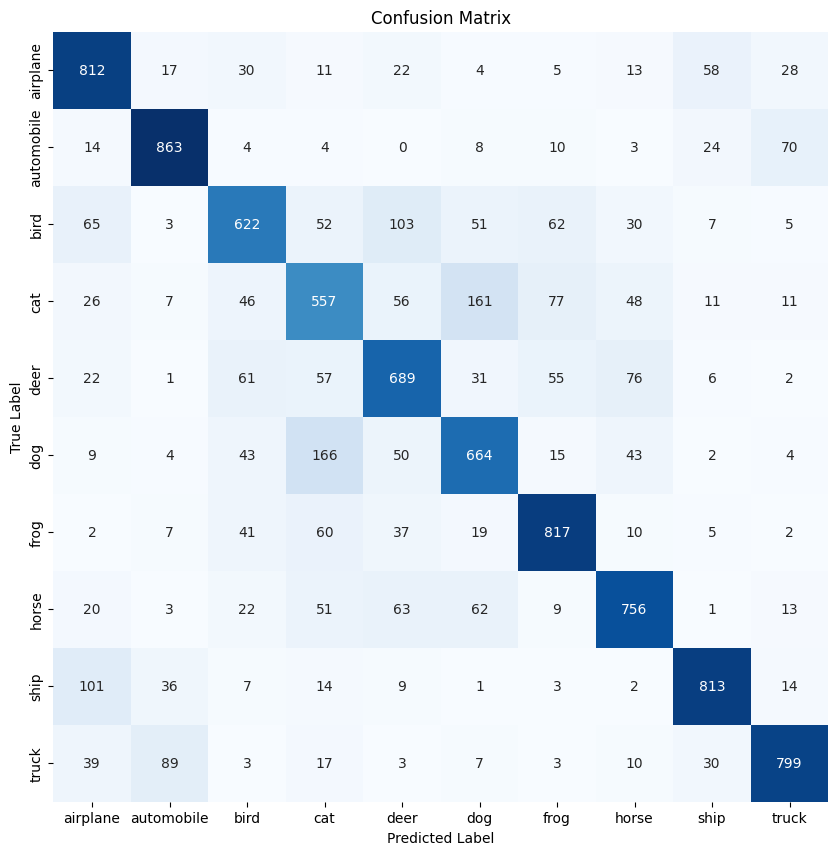

In [ ]:
import mindspore as ms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
# Load the best checkpoint and pre-trained model
best_ckpt_path = "./BestCheckpoint/resnet50-best.ckpt"  # Update with your path
param_dict = ms.load_checkpoint(best_ckpt_path)
ms.load_param_into_net(network, param_dict)

# Evaluate the model on the test set
test_acc = evaluate(dataset_val)
print(f"Test Accuracy: {test_acc: 5.3f}")

# Plotting training loss vs. validation loss (if available)
if 'train_losses' in locals() and 'val_losses' in locals():
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
else:
    print("Training and validation losses not available.")

# Generate confusion matrix
all_preds = []
all_labels = []
for images, labels in dataset_val.create_tuple_iterator():
    logits = network(images)
    pred = logits.argmax(axis=1)
    all_preds.extend(pred.asnumpy())
    all_labels.extend(labels.asnumpy())

cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)  # Assuming 'classes' is defined
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Making Predictions

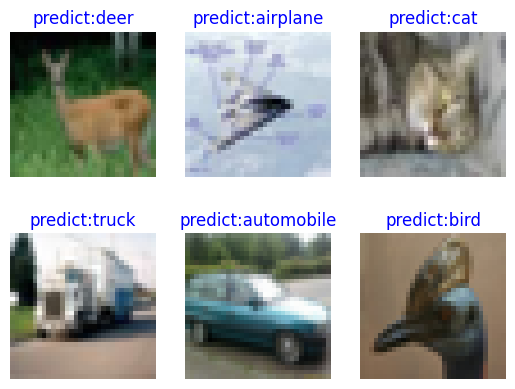

In [ ]:
import matplotlib.pyplot as plt


def visualize_model(best_ckpt_path, dataset_val):
    num_class = 10
    net = resnet50(num_class)
    # Load model parameters.
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    # Load the validation dataset.
    data = next(dataset_val.create_dict_iterator())
    images = data["image"]
    labels = data["label"]
    # Predict the image type.
    output = net(data['image'])
    pred = np.argmax(output.asnumpy(), axis=1)

    # Image classification
    classes = []

    with open(data_dir + "/batches.meta.txt", "r") as f:
        for line in f:
            line = line.rstrip()
            if line:
                classes.append(line)

    # Show the picture along with its corresponding predicted value.
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        # If the prediction is correct, it will appear in blue; otherwise, it will show up in red.
        color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
        plt.title('predict:{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


# Validate with test dataset
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)
